In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xmfaizan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:01<00:00, 116MB/s]


In [2]:
import torch
from torch import nn # neural network funcs
from torch.optim import Adam

In [3]:
import torchvision.transforms as transforms # used to modify and preprocess all the images
from torchvision import models
from torch.utils.data import Dataset, DataLoader

In [4]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
#reading ds
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (1167, 2)



,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [9]:
#check classes
print("Classes are: ")
print(data_df["category"].unique())

Classes are: 
[0 1 2]


In [10]:
print(data_df["category"].value_counts())

category
2    393
1    389
0    385
Name: count, dtype: int64


In [11]:
train=data_df.sample(frac=0.7,random_state=7)
test=data_df.drop(train.index)
#training 70 testing 30

In [12]:
label_encoder = LabelEncoder() # string classes to numeric
#preprocess all images to same properties
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    ])

In [13]:
#dataset class
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image, label

In [14]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

In [15]:
#hyperparameters
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [16]:
#dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
#pretrained model
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True
  #Ensures that all layers’ parameters (weights) are updated during training when set to True

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 59.7MB/s]


In [18]:
googlenet_model.fc
#gives the fully connected layer of the model from start to end

Linear(in_features=1024, out_features=1000, bias=True)

In [19]:
#as we only have 3 classes in the output
num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [20]:
#Instead of 1,000 outputs, the new layer has num_classes outputs, ensuring the model predicts the right number of categories for your task.

In [21]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

In [22]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()


Epoch 1/15, Train Loss: 1.9606 Train Accuracy 56.1812%

Epoch 2/15, Train Loss: 1.7619 Train Accuracy 63.2803%

Epoch 3/15, Train Loss: 1.5852 Train Accuracy 68.7882%

Epoch 4/15, Train Loss: 1.5252 Train Accuracy 68.0539%

Epoch 5/15, Train Loss: 1.5018 Train Accuracy 68.9106%

Epoch 6/15, Train Loss: 1.3903 Train Accuracy 72.4602%

Epoch 7/15, Train Loss: 1.3323 Train Accuracy 72.5826%

Epoch 8/15, Train Loss: 1.3103 Train Accuracy 76.1322%

Epoch 9/15, Train Loss: 1.0692 Train Accuracy 79.437%

Epoch 10/15, Train Loss: 1.1495 Train Accuracy 77.4786%

Epoch 11/15, Train Loss: 1.1331 Train Accuracy 78.3354%

Epoch 12/15, Train Loss: 0.9925 Train Accuracy 81.0282%

Epoch 13/15, Train Loss: 0.9279 Train Accuracy 82.2521%

Epoch 14/15, Train Loss: 0.8783 Train Accuracy 84.7001%

Epoch 15/15, Train Loss: 0.7535 Train Accuracy 85.1897%



In [23]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 82.86%


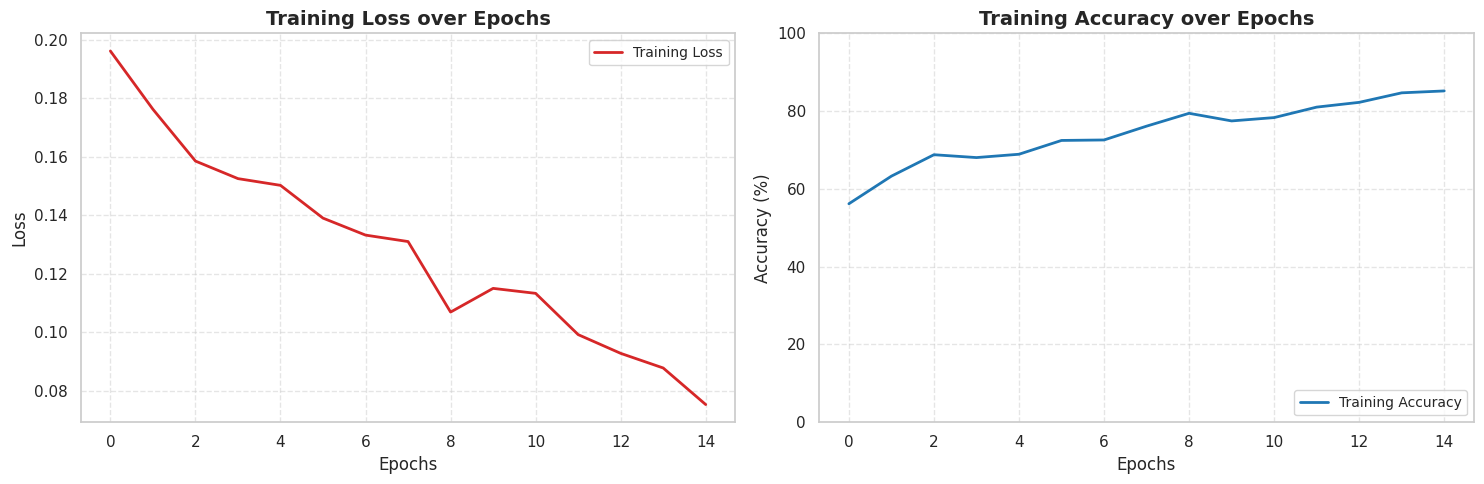

In [24]:
#visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme for cleaner aesthetics
sns.set_theme(style="whitegrid")

# Create subplots with shared x-axis for alignment
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True)

# Training Loss Plot
axs[0].plot(total_loss_train_plot, label='Training Loss', color='tab:red', linewidth=2)
axs[0].set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].legend(loc='upper right', fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.5)

# Training Accuracy Plot
axs[1].plot(total_acc_train_plot, label='Training Accuracy', color='tab:blue', linewidth=2)
axs[1].set_title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('Accuracy (%)', fontsize=12)
axs[1].set_ylim([0, 100])
axs[1].legend(loc='lower right', fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.5)

# Adjust spacing
plt.tight_layout()

# Show the plots
plt.show()


In [25]:
#Applying only last layer transfer learning
model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = False

In [26]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # Assuming 3 classes
model.fc.requires_grad = True
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [27]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()


Epoch 1/15, Train Loss: 1.9671 Train Accuracy 54.2228%

Epoch 2/15, Train Loss: 1.7971 Train Accuracy 60.8323%

Epoch 3/15, Train Loss: 1.7397 Train Accuracy 61.9339%

Epoch 4/15, Train Loss: 1.5741 Train Accuracy 68.0539%

Epoch 5/15, Train Loss: 1.5704 Train Accuracy 64.7491%

Epoch 6/15, Train Loss: 1.3641 Train Accuracy 72.705%

Epoch 7/15, Train Loss: 1.3581 Train Accuracy 72.705%

Epoch 8/15, Train Loss: 1.3003 Train Accuracy 73.929%

Epoch 9/15, Train Loss: 1.2839 Train Accuracy 74.541%

Epoch 10/15, Train Loss: 1.1155 Train Accuracy 78.0906%

Epoch 11/15, Train Loss: 1.0315 Train Accuracy 80.2938%

Epoch 12/15, Train Loss: 1.1886 Train Accuracy 77.3562%

Epoch 13/15, Train Loss: 1.053 Train Accuracy 81.2729%

Epoch 14/15, Train Loss: 0.9333 Train Accuracy 82.8641%

Epoch 15/15, Train Loss: 0.8019 Train Accuracy 85.3121%



In [28]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")

Accuracy Score is: 79.71%


Whole Model Transfer Learning:

    The entire model is fine-tuned, meaning all layers get updated during training.
    Useful when your dataset is large, or when the pre-trained features aren’t enough for your task.

Last Layer Transfer Learning:

    Only the last layer (classifier) is trained while earlier layers remain frozen.
    Faster and works well when the pre-trained model’s features already capture relevant information.

In [29]:
# learning from Learn PyTorch in 5 Projects – Tutorial Youtube Video by freeCodeCamp.org